In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from alibi.explainers import ALE
from alibi.explainers import plot_ale

import sys
sys.path.append('../')
import utils

2024-10-17 13:44:36.508373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 13:44:36.512719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 13:44:37.037370: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 13:44:38.138669: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 13:44:48.590815: W tensorflow/compiler/tf2

In [2]:
#import dataset
data = pd.read_csv("../../data/abalone.data",
                  names=["sex","length","diameter","height","whole weight",
                         "shucked weight","viscera weight","shell weight","rings"])

y = data['rings']
X = data.drop('rings', axis=1)

data.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Explaining ALEs

Saving figure MA2_corr_heatmap


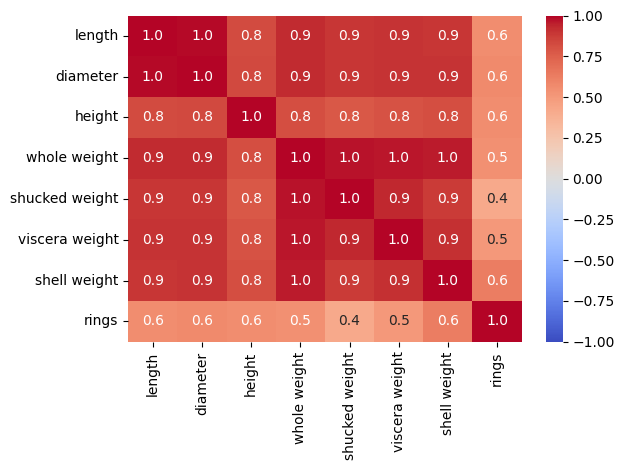

In [3]:
# Correlation heatmap
cont = [
    "length",
    "diameter",
    "height",
    "whole weight",
    "shucked weight",
    "viscera weight",
    "shell weight",
    "rings",
]
corr_matrix = pd.DataFrame(data[cont], columns=cont).corr()
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".1f", vmin=-1, vmax=1)

# Save figure
utils.save_fig("MA2_corr_heatmap")

Saving figure MA2_feature_corr


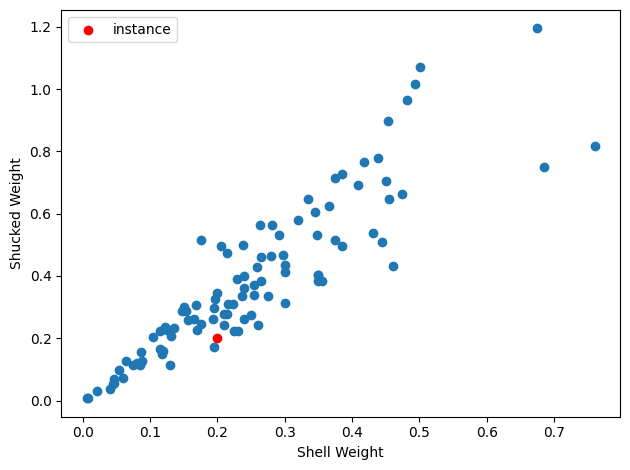

In [5]:
# scatter plot of shell weight vs shucked weight
sample = data.sample(100)

plt.scatter(sample['shell weight'], sample['shucked weight'])

# add red point for sample
plt.scatter(0.2, 0.2, color='red',label='instance')

plt.xlabel('Shell Weight')
plt.ylabel('Shucked Weight')
plt.legend()

# Save figure
utils.save_fig("MA2_feature_corr")

Saving figure MA2_ale_explanation


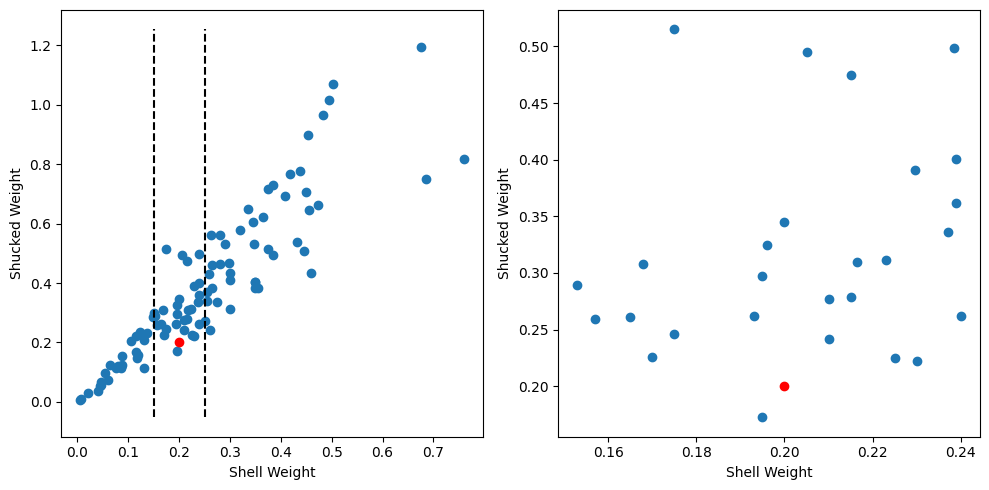

In [6]:


fig, ax = plt.subplots(1,2,figsize=(10, 5))

# show interval
ax[0].scatter(sample['shell weight'], sample['shucked weight'])
ax[0].scatter(0.2, 0.2, color='red',label='instance')

ymin, ymax = ax[0].get_ylim()
ax[0].vlines(x=0.15, ymin=ymin, ymax=ymax, color='black', linestyle='--')
ax[0].vlines(x=0.25, ymin=ymin, ymax=ymax, color='black', linestyle='--')

ax[0].set_xlabel('Shell Weight')
ax[0].set_ylabel('Shucked Weight')

# plot points within interval
sample_in_interval = sample[(sample['shell weight'] > 0.15) & (sample['shell weight'] < 0.25)]
ax[1].scatter(sample_in_interval['shell weight'], sample_in_interval['shucked weight'])
ax[1].scatter(0.2, 0.2, color='red',label='instance')

ax[1].set_xlabel('Shell Weight')
ax[1].set_ylabel('Shucked Weight')



# Save figure
utils.save_fig("MA2_ale_explanation")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Saving figure MA2_ale_explanation2


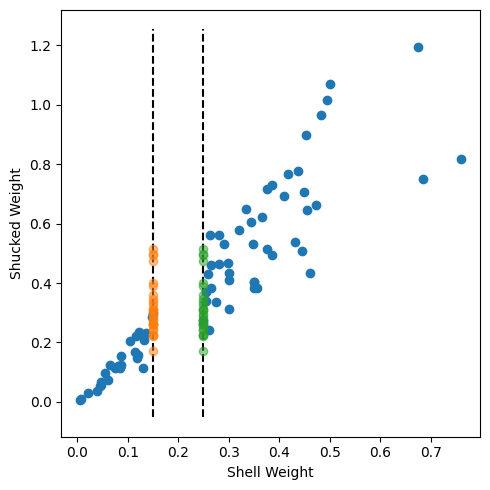

In [7]:
# get data for explanation plot
sample_adjusted = sample.copy()
sample__1p5 = sample_adjusted[(sample_adjusted['shell weight'] < 0.25) & (sample_adjusted['shell weight'] > 0.15)]
sample__1p5['shell weight'] = [0.15 for i in range(len(sample__1p5))]

sample_2p5 = sample__1p5.copy() 
sample_2p5['shell weight'] = [0.25 for i in range(len(sample_2p5))]

sample_adjusted = sample[(sample['shell weight'] >= 0.25)]
sample_adjusted = sample_adjusted.append(sample[(sample['shell weight'] <= 0.15)])


fig, ax = plt.subplots(1,1,figsize=(5, 5))
# show new sample points
ax.scatter(sample_adjusted['shell weight'], sample_adjusted['shucked weight'])
ax.scatter(sample_2p5['shell weight'], sample_2p5['shucked weight'],alpha=0.5,color='tab:green')
ax.scatter(sample__1p5['shell weight'], sample__1p5['shucked weight'],alpha=0.5,color='tab:orange')
ax.vlines(x=0.15, ymin=ymin, ymax=ymax, color='black', linestyle='--',zorder=-1)
ax.vlines(x=0.25, ymin=ymin, ymax=ymax, color='black', linestyle='--',zorder=-1)

ax.set_xlabel('Shell Weight')
ax.set_ylabel('Shucked Weight')


# Save figure
utils.save_fig("MA2_ale_explanation2")

## Model

In [8]:
y = data["rings"]
X = data[["sex", "length", "height", "shucked weight", "viscera weight", "shell weight"]]

# Create dummy variables
X['sex.M'] = [1 if s == 'M' else 0 for s in X['sex']]
X['sex.F'] = [1 if s == 'F' else 0 for s in X['sex']]
X['sex.I'] = [1 if s == 'I' else 0 for s in X['sex']]
X = X.drop('sex', axis=1)

X.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


In [9]:
# Train model
model = RandomForestRegressor()
model.fit(X.to_numpy(), y)

RandomForestRegressor()

X has feature names, but RandomForestRegressor was fitted without feature names


Text(0.5, 0, 'Actual')

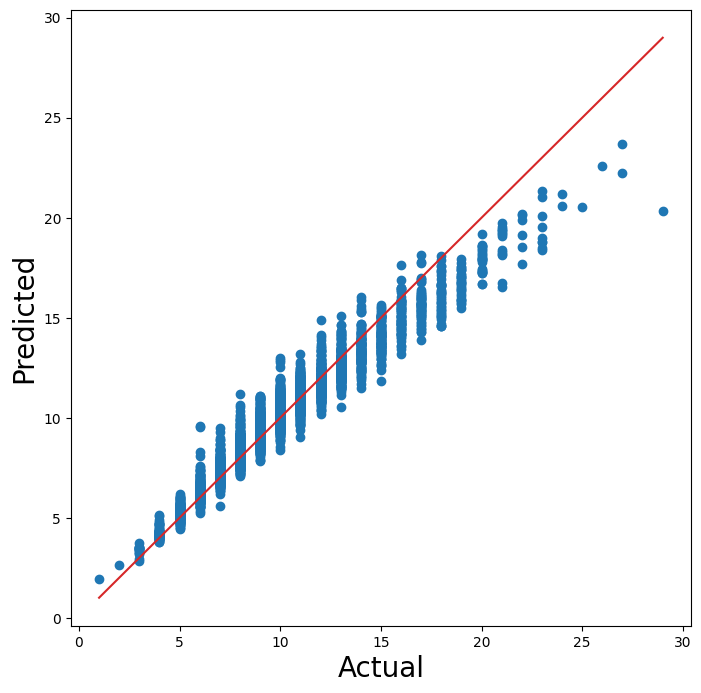

In [10]:
#Get predictions
y_pred = model.predict(X)

# Model evaluation
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

plt.scatter(y,y_pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], color='tab:red')

plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)

## Accumulated Local Effects (ALEs)

In [11]:
# Get ALE explanation
ale = ALE(model.predict , feature_names=X.columns, target_names=['rings'])
exp = ale.explain(X.to_numpy())

Saving figure MA2_ale_1


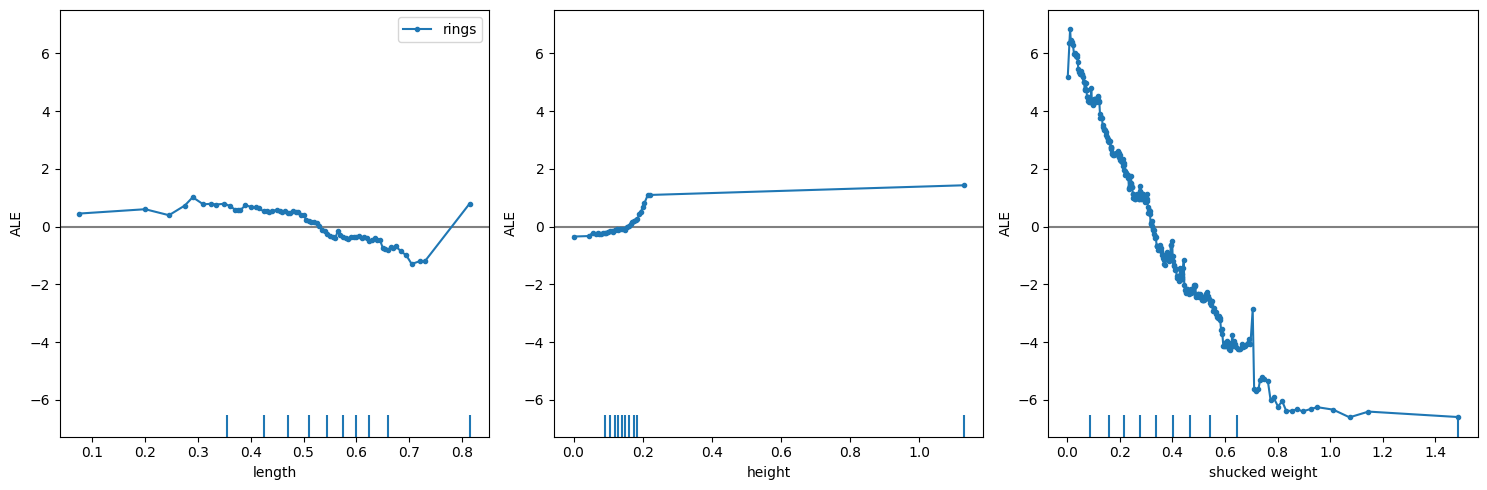

In [12]:
# Plot ALE explanation for first 3 features
plot_ale(exp, features=[0,1,2], fig_kw={'figwidth':15, 'figheight': 5})

# Save figure
utils.save_fig("MA2_ale_1")

Saving figure MA2_ale_2


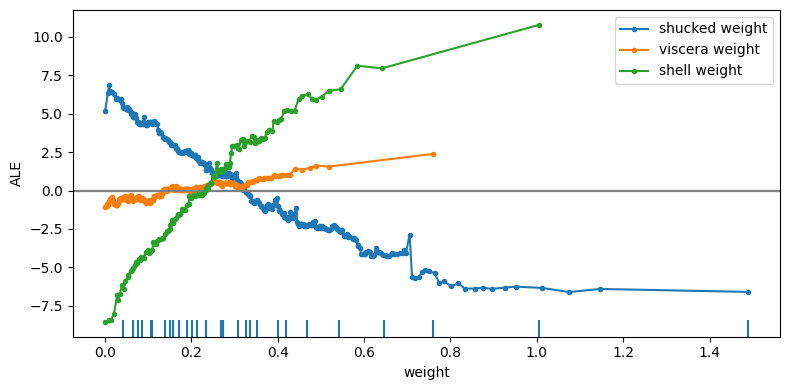

In [13]:
# Plot ALE for weight features
fig, ax = plt.subplots(1, 1, figsize=(8, 4))


plot_ale(exp, features=[2], ax=ax, line_kw={'label': 'shucked weight'})
plot_ale(exp, features=[3], ax=ax, line_kw={'label': 'viscera weight'})
plot_ale(exp, features=[4], ax=ax, line_kw={'label': 'shell weight'})

ax.set_xlabel('weight')

# Save figure
utils.save_fig("MA2_ale_2")

In [14]:
# Adjust intervals
ale = ALE(model.predict , feature_names=X.columns, target_names=['rings'])
exp = ale.explain(X.to_numpy(),min_bin_points=50)

Saving figure MA2_ale_3


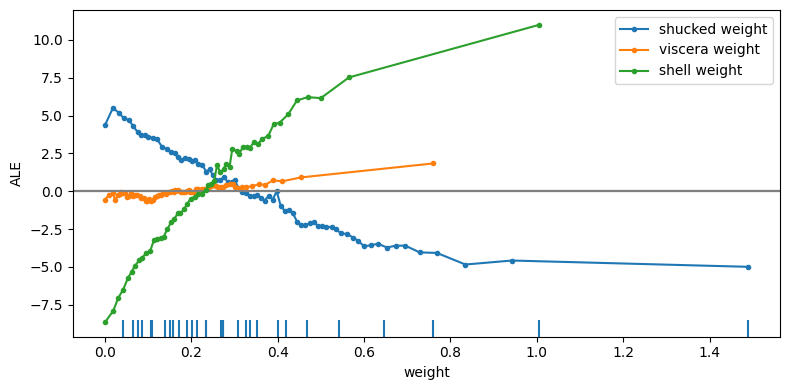

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

plot_ale(exp, features=[2], ax=ax, line_kw={'label': 'shucked weight'})
plot_ale(exp, features=[3], ax=ax, line_kw={'label': 'viscera weight'})
plot_ale(exp, features=[4], ax=ax, line_kw={'label': 'shell weight'})

ax.set_xlabel('weight')

# Save figure
utils.save_fig("MA2_ale_3")